In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-prediction-problem-dataset/test_Y3wMUE5_7gLdaTN.csv
/kaggle/input/loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv


In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [4]:
path = '/kaggle/input/loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv'
df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
df = df.set_index('Loan_ID')
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


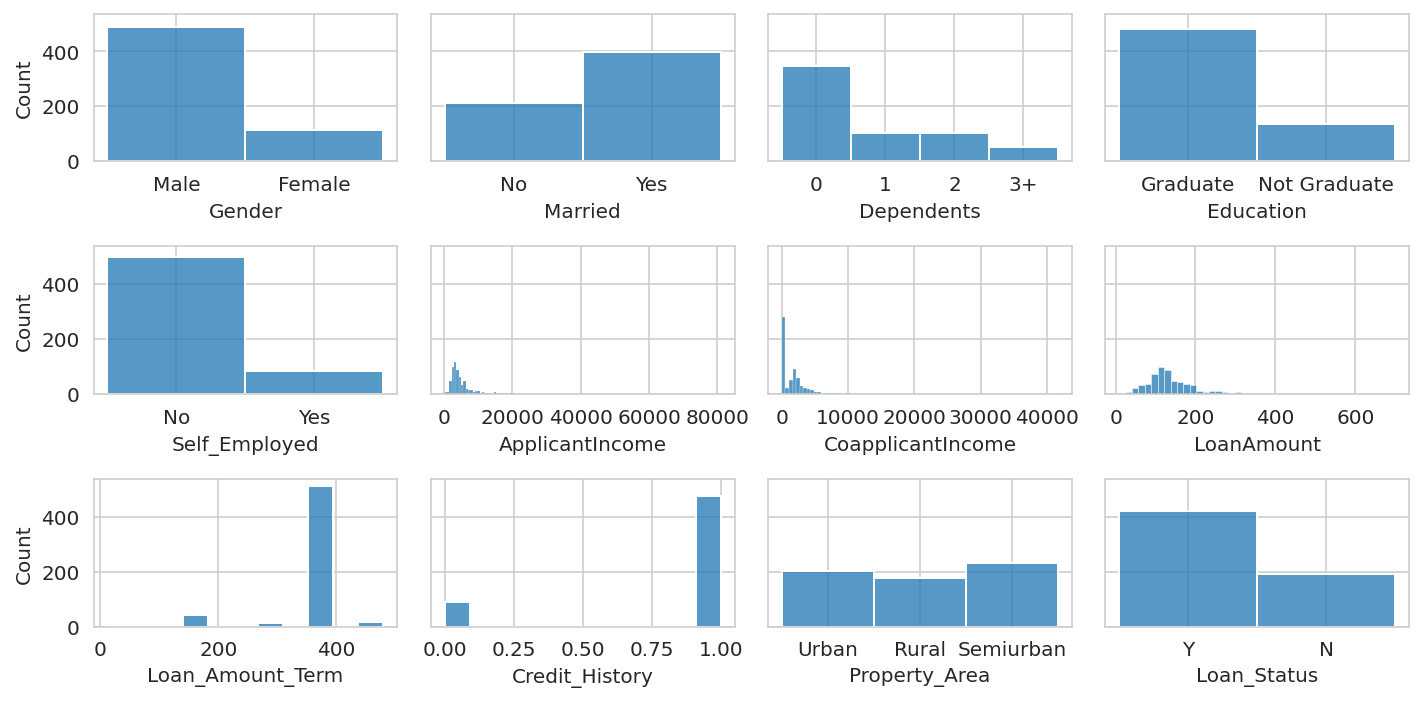

In [7]:
ncols = 4
nrows = np.ceil(len(df.columns)/ncols).astype(int)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharey=True, figsize=(10,5))

for idx, c in enumerate(df.columns):
    row = idx // ncols
    col = idx % ncols
    sns.histplot(df, x=c, ax=axs[row, col])
plt.tight_layout()

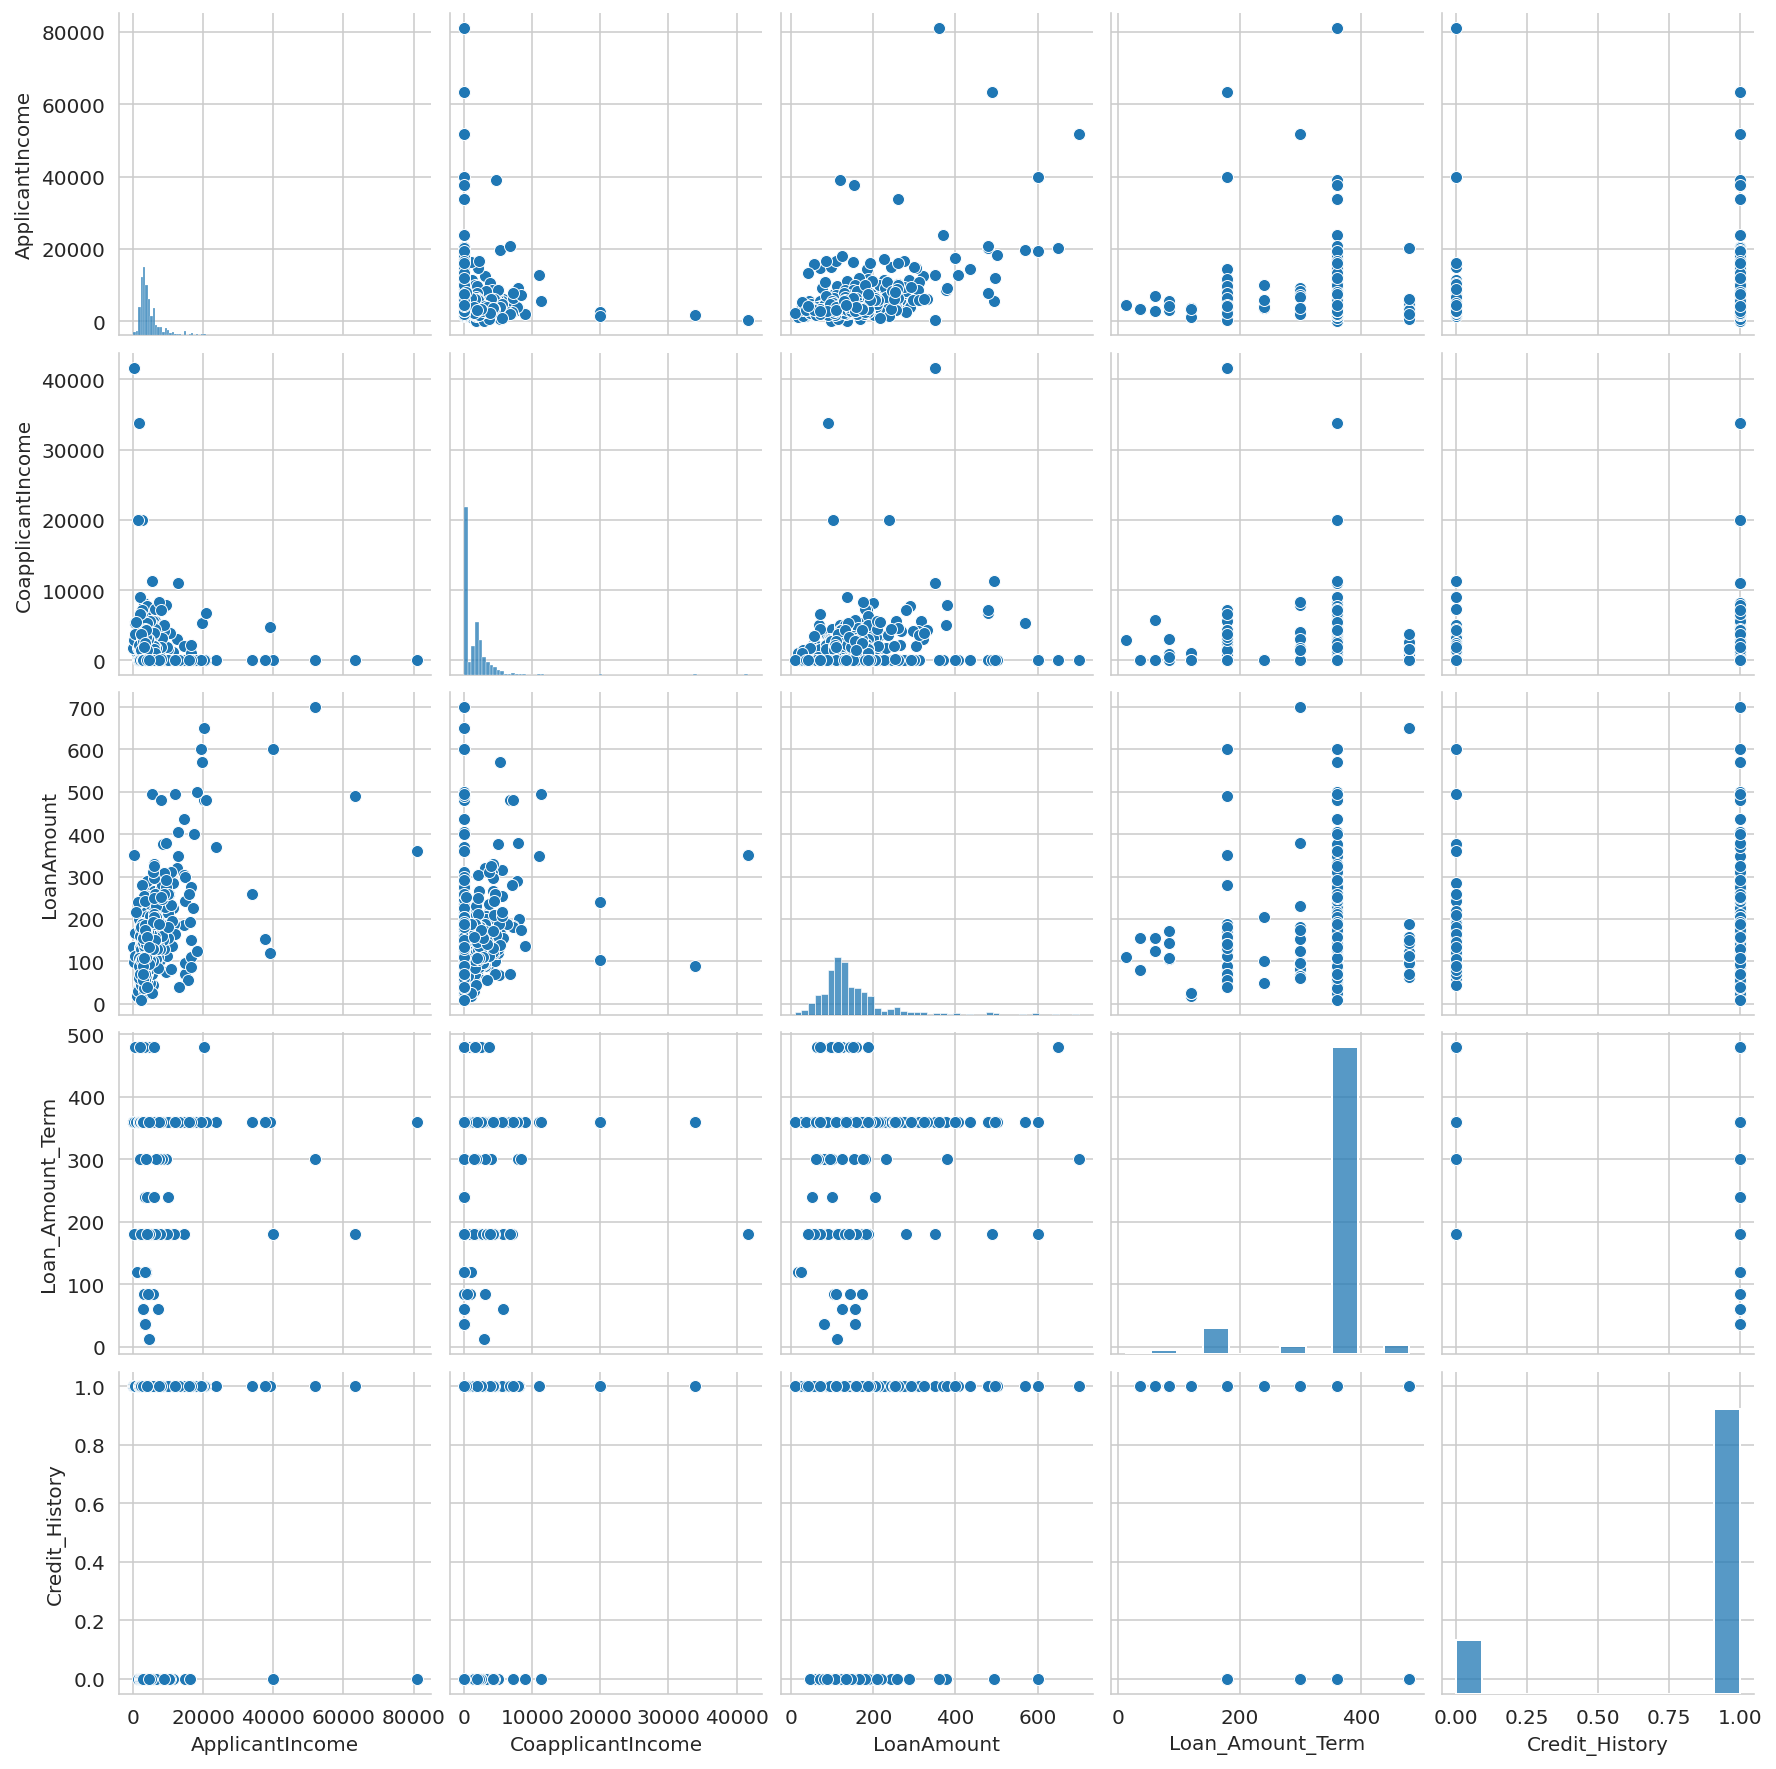

In [8]:
sns.pairplot(df)

<AxesSubplot:xlabel='Loan_Amount_Term', ylabel='LoanAmount'>

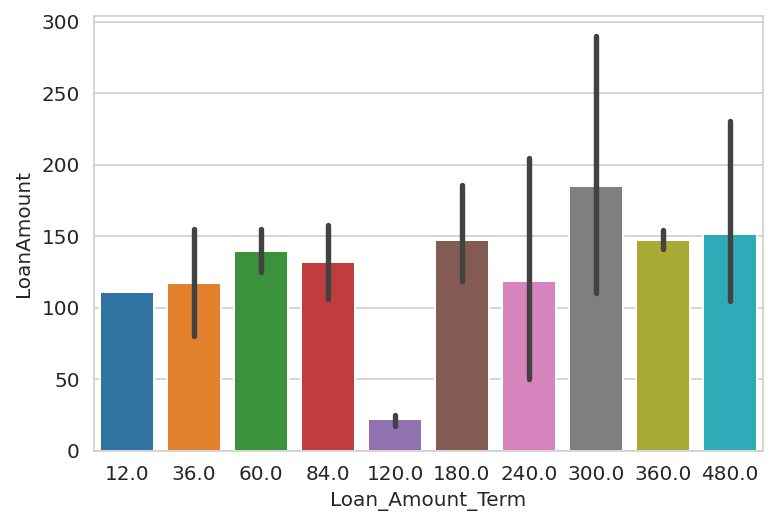

In [9]:
sns.barplot(x=df['Loan_Amount_Term'],y=df['LoanAmount'])

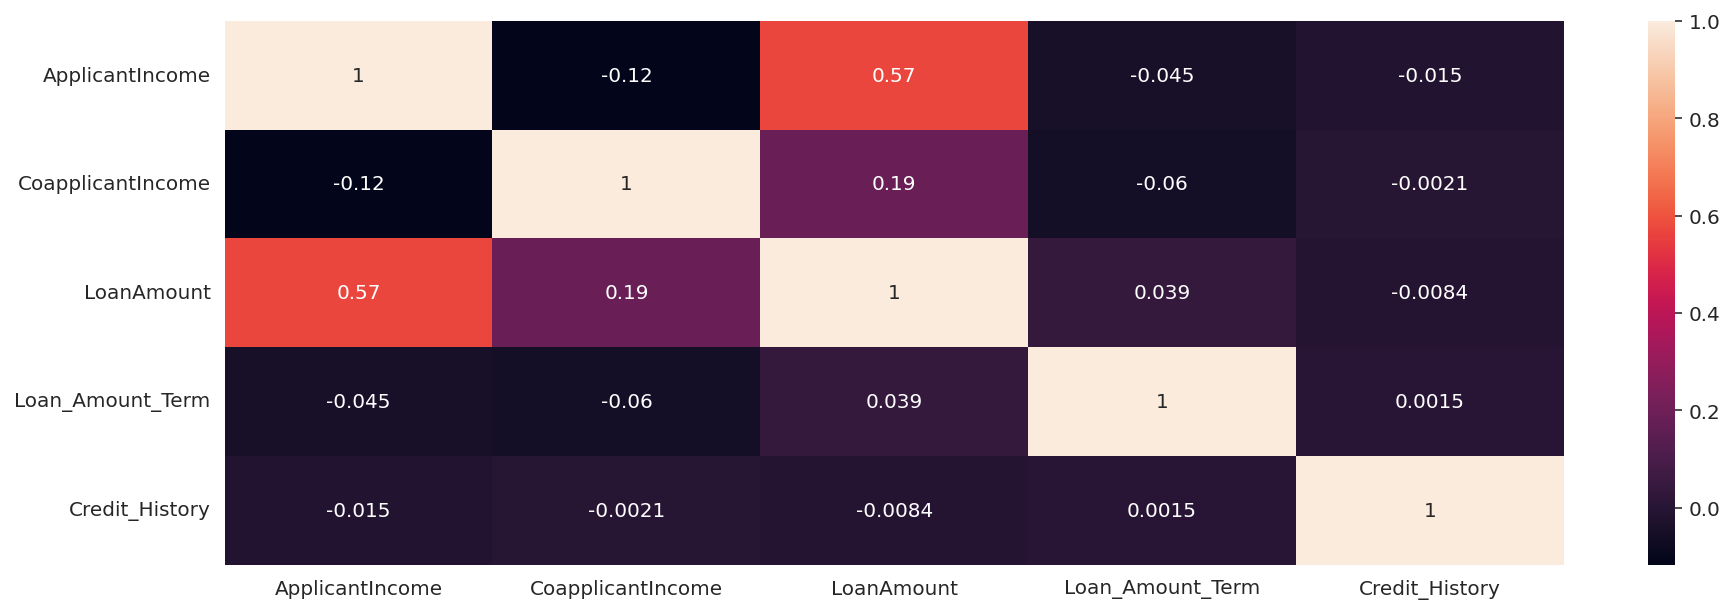

In [10]:
plt.figure(figsize=(15,5))
sns.heatmap(df.corr(),annot=True)
plt.show()

In [11]:
df['Credit_History'] = df['Credit_History'].astype(object)

In [12]:
target = 'Loan_Status'
y = df[target]
df.drop(columns=[target], inplace=True)

In [13]:
y.value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

In [14]:
num_attributes = [c for c in df.columns if df[c].dtype != object]
num_attributes

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

In [15]:
for c in num_attributes:
    df[c] = df[c].fillna(df[c].mean())

In [16]:
model = LogisticRegression(max_iter=1000, random_state=0)
X_num = df[num_attributes].values
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
cross_val_score(model, X_num, y, cv=skf).mean()

0.6856857257097161

In [17]:
total_income_att = 'TotalIncome'
extra_num_attributes = num_attributes + [total_income_att]
df[total_income_att] = df['ApplicantIncome'] + df['CoapplicantIncome']
X_ti = df[extra_num_attributes].values
cross_val_score(model, X_ti, y, cv=skf).mean()

0.6856857257097161

In [18]:
cat_attributes = [c for c in df.columns if df[c].dtype == object]
cat_attributes

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Credit_History',
 'Property_Area']

In [19]:
# NA handling
for c in cat_attributes:
    df[c] = df[c].fillna(df[c].mode()[0])

In [23]:
test = pd.read_csv('/kaggle/input/loan-prediction-problem-dataset/test_Y3wMUE5_7gLdaTN.csv')
train = pd.read_csv('/kaggle/input/loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv')
df = pd.concat([train, test])
df.reset_index(drop = True, inplace = True)
print(df.shape)
df.head()

(981, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            981 non-null    object 
 1   Gender             957 non-null    object 
 2   Married            978 non-null    object 
 3   Dependents         956 non-null    object 
 4   Education          981 non-null    object 
 5   Self_Employed      926 non-null    object 
 6   ApplicantIncome    981 non-null    int64  
 7   CoapplicantIncome  981 non-null    float64
 8   LoanAmount         954 non-null    float64
 9   Loan_Amount_Term   961 non-null    float64
 10  Credit_History     902 non-null    float64
 11  Property_Area      981 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 99.8+ KB


In [25]:
train.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [26]:
test.isna().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

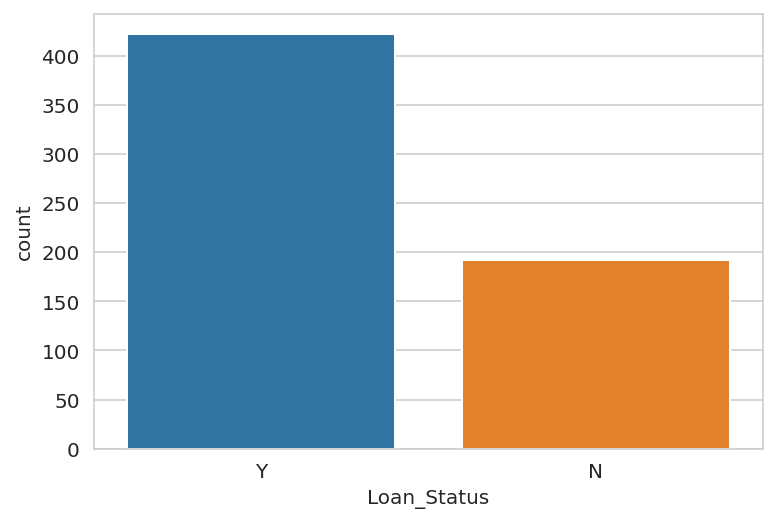

In [27]:
sns.countplot(data = train, x = 'Loan_Status')
plt.show()

In [28]:
default_data = train.query("Loan_Status == 'N' ")
default_data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N
13,LP001029,Male,No,0,Graduate,No,1853,2840.0,114.0,360.0,1.0,Rural,N
17,LP001036,Female,No,0,Graduate,No,3510,0.0,76.0,360.0,0.0,Urban,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,LP002941,Male,Yes,2,Not Graduate,Yes,6383,1000.0,187.0,360.0,1.0,Rural,N
597,LP002943,Male,No,NaN,Graduate,No,2987,0.0,88.0,360.0,0.0,Semiurban,N
600,LP002949,Female,No,3+,Graduate,NaN,416,41667.0,350.0,180.0,NaN,Urban,N
605,LP002960,Male,Yes,0,Not Graduate,No,2400,3800.0,NaN,180.0,1.0,Urban,N


In [31]:
from scipy import  stats
from statsmodels.stats.proportion import proportions_ztest
from sklearn.linear_model import LogisticRegression
import warnings
warnings.simplefilter("ignore")

In [32]:
p1 = stats.shapiro(df.query("Self_Employed == 'Yes' ")['ApplicantIncome'])
p2 = stats.shapiro(df.query("Self_Employed == 'No' ")['ApplicantIncome'])
print(f"{p1[1]}, {p2[1]}")

6.469123197197502e-13, 7.006492321624085e-45


In [33]:
p3 = stats.mannwhitneyu(df.query("Self_Employed == 'Yes' ")['ApplicantIncome'], df.query("Self_Employed == 'No' ")['ApplicantIncome'])

if p3[1] < 0.05:
    print("Statistical tests do not reject that those who are employed have higher incomes on average")
else:
    print("Statistical tests reject that those who are employed have higher incomes on average")

Statistical tests do not reject that those who are employed have higher incomes on average


In [34]:
# The number of defaults
train[train['Loan_Status'] == 'N']['Credit_History'].value_counts()

1.0    97
0.0    82
Name: Credit_History, dtype: int64

In [35]:
num_def = np.array([97, 82])

In [36]:
# Observation count 
train.Credit_History.value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

In [37]:
ob_count = np.array([475, 89])
proportions_ztest(count = num_def, nobs = ob_count)

(-13.339117169122137, 1.3707318825450035e-40)

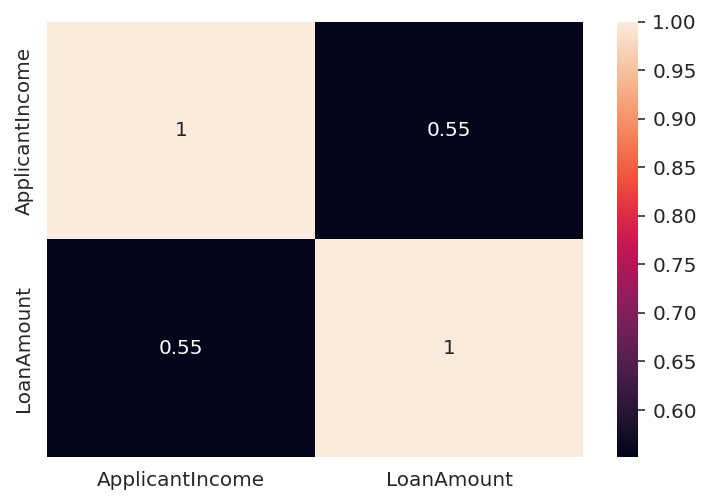

In [38]:
cor_data = df[['ApplicantIncome', 'LoanAmount']]
sns.heatmap(cor_data.corr(), annot = True)
plt.show()

In [40]:
df.Loan_Status = np.where(df.Loan_Status.isna(), 'Test', df.Loan_Status)
df.Gender = df.Gender.fillna(df.Gender.mode()[0])
df.Married = df.Married.fillna(df.Married.mode()[0])
df.Dependents = df.Dependents.fillna(df.Dependents.mode()[0])
df.Self_Employed = df.Self_Employed.fillna(df.Self_Employed.mode()[0])
df.LoanAmount = df.LoanAmount.fillna(df.groupby('Education')['LoanAmount'].transform('median'))
df.Loan_Amount_Term = df.Loan_Amount_Term.fillna(df.groupby('Education')['Loan_Amount_Term'].transform('median'))
df.Credit_History = df.Credit_History.fillna(df['Credit_History'].median())

In [41]:
df.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [42]:
df.drop('Loan_ID', axis = 1, inplace = True)
train_set = df[df['Loan_Status'] != 'Test']
test_set = df[df['Loan_Status'] == 'Test']

In [43]:
Y = train_set.Loan_Status
Y = np.where(Y == 'Y', 1, 0)
X = pd.get_dummies(train_set.drop('Loan_Status', axis = 1), drop_first = True)
X

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,5849,0.0,130.5,360.0,1.0,1,0,0,0,0,0,0,0,1
1,4583,1508.0,128.0,360.0,1.0,1,1,1,0,0,0,0,0,0
2,3000,0.0,66.0,360.0,1.0,1,1,0,0,0,0,1,0,1
3,2583,2358.0,120.0,360.0,1.0,1,1,0,0,0,1,0,0,1
4,6000,0.0,141.0,360.0,1.0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,71.0,360.0,1.0,0,0,0,0,0,0,0,0,0
610,4106,0.0,40.0,180.0,1.0,1,1,0,0,1,0,0,0,0
611,8072,240.0,253.0,360.0,1.0,1,1,1,0,0,0,0,0,1
612,7583,0.0,187.0,360.0,1.0,1,1,0,1,0,0,0,0,1


In [45]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X = pd.DataFrame(X)
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.072991,-0.554487,-0.180823,0.273231,0.411733,0.472343,-1.372089,-0.446339,-0.443713,-0.300975,-0.528362,-0.392601,-0.782016,1.428147
1,-0.134412,-0.038732,-0.210564,0.273231,0.411733,0.472343,0.728816,2.240448,-0.443713,-0.300975,-0.528362,-0.392601,-0.782016,-0.700208
2,-0.393747,-0.554487,-0.948154,0.273231,0.411733,0.472343,0.728816,-0.446339,-0.443713,-0.300975,-0.528362,2.547117,-0.782016,1.428147
3,-0.462062,0.251980,-0.305737,0.273231,0.411733,0.472343,0.728816,-0.446339,-0.443713,-0.300975,1.892641,-0.392601,-0.782016,1.428147
4,0.097728,-0.554487,-0.055908,0.273231,0.411733,0.472343,-1.372089,-0.446339,-0.443713,-0.300975,-0.528362,-0.392601,-0.782016,1.428147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,-0.410130,-0.554487,-0.888671,0.273231,0.411733,-2.117107,-1.372089,-0.446339,-0.443713,-0.300975,-0.528362,-0.392601,-0.782016,-0.700208
610,-0.212557,-0.554487,-1.257466,-2.522836,0.411733,0.472343,0.728816,-0.446339,-0.443713,3.322532,-0.528362,-0.392601,-0.782016,-0.700208
611,0.437174,-0.472404,1.276512,0.273231,0.411733,0.472343,0.728816,2.240448,-0.443713,-0.300975,-0.528362,-0.392601,-0.782016,1.428147
612,0.357064,-0.554487,0.491336,0.273231,0.411733,0.472343,0.728816,-0.446339,2.253710,-0.300975,-0.528362,-0.392601,-0.782016,1.428147


In [49]:
from sklearn.experimental import enable_halving_search_cv 

In [50]:
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, StratifiedKFold, cross_val_score

In [51]:

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

models = []
cv_score = []
fold = 0
for train_index, test_index in outer_cv.split(X, Y):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = Y[train_index], Y[test_index]
        params = {'C': np.logspace(-4, 4, 20),
                   'solver':['liblinear'],
                  'penalty': ['l1', 'l2']}
        model = LogisticRegression()
        grid_search = HalvingGridSearchCV(model, param_grid = params, cv =  inner_cv,  scoring='accuracy')
        grid_result = grid_search.fit(X_train, y_train)
        best_params = grid_result.best_params_
        models.append(model.set_params(**best_params))
        score = grid_search.score(X_test, y_test)
        cv_score.append(score)
        fold = fold + 1
        print(f'Fold {fold}: train score => {score}')
print(f'CV score = > {np.mean(cv_score)}')

Fold 1: train score => 0.8048780487804879
Fold 2: train score => 0.7967479674796748
Fold 3: train score => 0.8130081300813008
Fold 4: train score => 0.8048780487804879
Fold 5: train score => 0.8360655737704918
CV score = > 0.8111155537784887


In [52]:
best_model = LogisticRegression()
best_model.set_params(**(models[4].get_params()))
best_model

LogisticRegression(C=0.0018329807108324356, solver='liblinear')

In [53]:
best_model.fit(X, Y)
best_model.score(X, Y)

0.8127035830618893

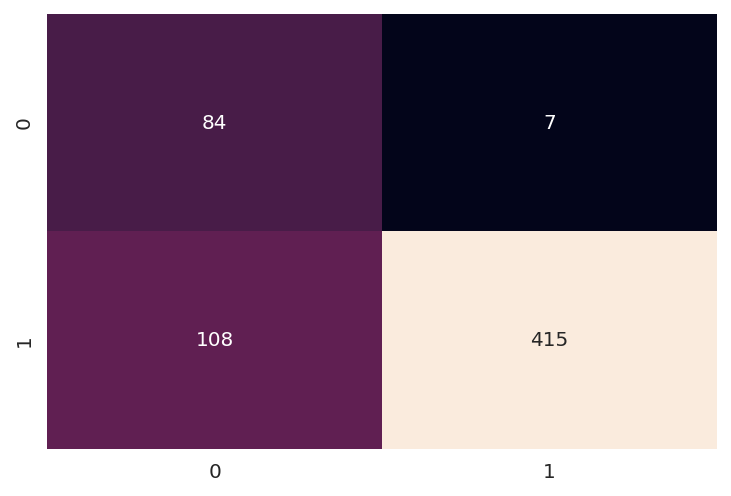

In [55]:
from sklearn.metrics import confusion_matrix
y_pred = best_model.predict(X)
cf = confusion_matrix(y_pred, Y)
sns.heatmap(cf, annot = True, fmt = '.4g', cbar=False);